<a href="https://colab.research.google.com/github/EAName/yelp-reviews/blob/main/Yelp_NLP_RNN_RA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from packaging import version

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization


import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statistics

%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn.model_selection import train_test_split

from datetime import datetime


## Verify TensorFlow version and Keras version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Reviews Dataset

In [5]:
df =pd.read_csv('/content/gdrive/MyDrive/Data/yelp_reviews_clean_version4_st_louis.csv')

In [6]:
df = df.iloc[:,3:]
df['stars'] = df['stars'].replace([1.0, 2.0, 3.0, 4.0, 5.0], [1, 2, 3, 4, 5])
df['stars'] = df['stars'].astype(int)

In [7]:
train, test = train_test_split(df, test_size=0.7, random_state = 42)

In [8]:
test, val = train_test_split(test, test_size=0.5, random_state = 42)

In [9]:
df2 = train
labels = df2.pop('stars')
train_ds = tf.data.Dataset.from_tensor_slices((df2, labels))
train_ds = train_ds.batch(32)

In [10]:
df2 = test
labels = df2.pop('stars')
test_ds = tf.data.Dataset.from_tensor_slices((df2, labels))
test_ds = test_ds.batch(32)

In [11]:
df2 = val
labels = df2.pop('stars')
val_ds = tf.data.Dataset.from_tensor_slices((df2, labels))
val_ds = val_ds.batch(32)

In [12]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [13]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {:.3f}'.format(accuracy_score(test_labels, predictions)))
    print('Mean Absolute Error: {:.3f}'.format(mean_absolute_error(test_labels, predictions)))
    print('Root Mean Square Error: {:.3f}'.format(np.sqrt(MSE(test_labels, predictions))))
    print('Mean Square Error: {:.3f}'.format(MSE(test_labels, predictions, squared = True)))

In [27]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5'])
    ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])

## Preparing Integer Sequence Datasets

In [16]:
max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [17]:
test_data = [(example.numpy(), label.numpy()) for example, label in int_test_ds]
test_y = []

for i in range(len(test)//32):
  for j in range(32):
    test_y.append(test_data[i][1][j])

for j in range(len(test)%32):
  test_y.append(test_data[len(test)//32][1][j])

test_y = np.array(test_y)

## Bi-directional RNN

When translating in real-time, it would help to have access to worlds towards the end of a sentence, say, as well as earlier words in the sentence. One way to use the later words in the sentence is to feed the words into our RNN backward. So if we create two independent RNNs, we can feed one the words in their forward, or natural order, and the second gets their words in the revser order. This is the idea behind `Bi-directional RNNS`:

## Sequence Model Built on One-Hot Encoded Vector Sequences

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               264448    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 264,708
Trainable params: 264,708
Non-trainable params: 0
_______________________________________________________

## Training Sequence Model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 62s 15ms/step - loss: 0.5771 - accuracy: 0.7939 - val_loss: 0.4150 - val_accuracy: 0.8595
Epoch 2/200
3563/3563 [==============================] - 53s 15ms/step - loss: 0.4418 - accuracy: 0.8511 - val_loss: 0.4024 - val_accuracy: 0.8605
Epoch 3/200
3563/3563 [==============================] - 53s 15ms/step - loss: 0.4247 - accuracy: 0.8561 - val_loss: 0.3980 - val_accuracy: 0.8620
Epoch 4/200
3563/3563 [==============================] - 53s 15ms/step - loss: 0.4155 - accuracy: 0.8592 - val_loss: 0.3957 - val_accuracy: 0.8638
Epoch 5/200
3563/3563 [==============================] - 53s 15ms/step - loss: 0.4074 - accuracy: 0.8616 - val_loss: 0.3998 - val_accuracy: 0.8643
Epoch 6/200
3563/3563 [==============================] - 53s 15ms/step - loss: 0.4018 - accuracy: 0.8638 - val_loss: 0.3946 - val_accuracy: 0.8643
Epoch 7/200
3563/3563 [==============================] - 53s 15ms/step - loss: 0.3967 - accuracy: 0.8658 - val_loss: 0

## Two ways to obtain word embeddings

1. `Learn word embeddings jointly with the main task you care about` (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
2. Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called `pretrained word embeddings`.


## Instantiating An Embedding Layer

The Embedding layer takes at least two arguments: the number of possible tokens and the dimensionality of the embeddings (here, 256).

In [18]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors

The Embedding layer takes as input a rank-2 tensor of integers, of shape `(batch_size, sequence_length)`, where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape `(batch_size, sequence_length, embedding_ dimensionality)`.Again, embedding_ dimensionality is 256 above.

## Model Leveraging Trained Embedding Layer

One input is a sequence of integers.
1. Encode the integers into binary 20,000-dimensional vectors.
2. Add a bidirectional LSTM.
3. Finally, add a classification layer.

In [20]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         256000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 330,244
Trainable params: 330,244
Non-trainable params: 0
_____________________________________________________

KeyboardInterrupt: ignored

## Understanding Padding and Masking

One thing that’s slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the `output_sequence_length=max_ length` option in TextVectorization (with `max_length equal` to 150): sentences longer than 150 tokens are truncated to a length of 150 tokens, and sentences shorter than 150 tokens are padded with zeros at the end so that they can be concatenated together with other sequences to form contiguous batches.

The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There’s an API for that: `masking`.

<div class="alert alert-block alert-success"><b>tf.keras.layers.Masking</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking</div>

## Model Leveraging Embedding Layer With Masking Enabled

In [21]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         256000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 330,374
Trainable params: 330,374
Non-trainable params: 0
_____________________________________________________

In [22]:
model.evaluate(int_test_ds)[0]

3198/3198 [==============================] - 33s 10ms/step - loss: 0.8309 - accuracy: 0.6435


0.8309476375579834

In [23]:
plot_history(history)

NameError: ignored

In [24]:
pred1= model.predict(int_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 33s 9ms/step


In [25]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.75      0.71     11464
           2       0.47      0.31      0.37      9191
           3       0.48      0.40      0.43     12304
           4       0.53      0.51      0.52     25982
           5       0.75      0.83      0.79     43391

    accuracy                           0.64    102332
   macro avg       0.58      0.56      0.57    102332
weighted avg       0.63      0.64      0.63    102332

Accuracy Score: 0.643
Mean Absolute Error: 0.433
Root Mean Square Error: 0.805
Mean Square Error: 0.648


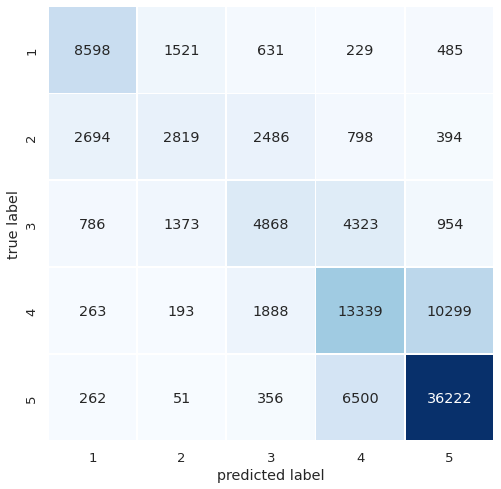

In [28]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

## Using Pretrained Word Embeddings

The rationale behind using `pretrained word embedding`s in natural language processing is much the same as for using pretrained convnets in image classification: *you don’t have enough data available to learn truly powerful features on your own*, but you expect that the features you need are fairly generic—that is, common visual features or semantic features. In this case, it makes sense to reuse features learned on a different problem.

The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the `Word2Vec` algorithm (https://code.google.com/archive/p/word2vec), developed by Tomas Mikolov at Google in 2013. `Word2Vec` dimensions capture specific semantic properties, such as gender.

There are various precomputed databases of word embeddings that you can download and use in a Keras Embedding layer. `Word2vec` is one of them. Another popular one is called `Global Vectors for Word Representatio`n (GloVe, https://nlp.stanford.edu/projects/glove), which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data.

First, let’s download the GloVe word embeddings precomputed on the 2014 English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).

<div class="alert alert-block alert-success"><b>GloVe: Global Vectors for Word Representation</b><br>
https://nlp.stanford.edu/projects/glove/</div>

In [29]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-10-29 03:59:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-29 03:59:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-29 03:59:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Parsing The GloVe Word-Embeddings File

First line of `glove.6B.100d.txt`:

`the -0.038194 -0.24487 0.72812 ...`

In [30]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


## Preparing The GloVe Word-Embeddings Matrix

Next, let’s build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry *i* contains the `embedding_dim`-dimensional vector for the word of index *i* in the reference word index (built during tokenization).

In [31]:
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

We’re now ready to train a new model—identical to our previous model, but leveraging the `100-dimensional` pretrained GloVe embeddings instead of `256-dimensional` learned embeddings.

# **LSTM**

# **1000 Vocab Size**

# **Experiment 1 (32 units, bidirectional, dropout = 0.5)**

## Model Leveraging Pretrained (GloVe) Embedding Layer

In [33]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start = datetime.now()

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")

end = datetime.now()
print('\nProcessing Time:', end - start, '\n')

model.evaluate(int_test_ds)[0]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         100000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 134,438
Trainable params: 34,438
Non-trainable params: 100,000
________________________________________________

0.8496147990226746

In [34]:
model.evaluate(int_test_ds)[0]

3198/3198 [==============================] - 26s 8ms/step - loss: 0.8496 - accuracy: 0.6341


0.8496147990226746

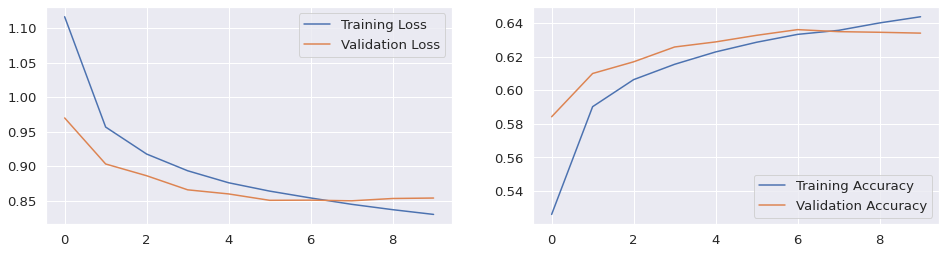

In [35]:
plot_history(history)

In [36]:
pred1= model.predict(int_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 28s 8ms/step


In [37]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.74      0.70     11464
           2       0.43      0.36      0.39      9191
           3       0.44      0.42      0.43     12304
           4       0.53      0.47      0.50     25982
           5       0.76      0.82      0.79     43391

    accuracy                           0.63    102332
   macro avg       0.56      0.56      0.56    102332
weighted avg       0.62      0.63      0.63    102332

Accuracy Score: 0.634
Mean Absolute Error: 0.448
Root Mean Square Error: 0.825
Mean Square Error: 0.680


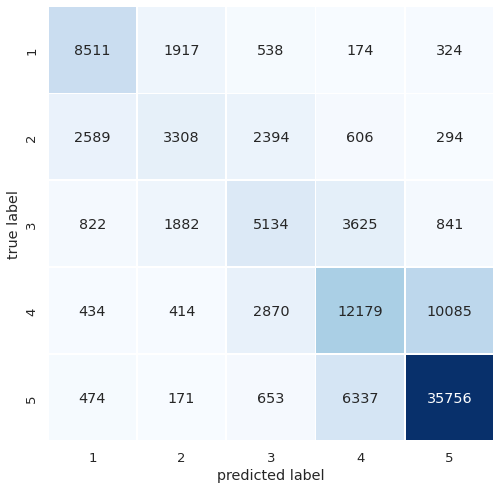

In [38]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)